In [1]:
%pylab inline

import pandas as pd
import numpy as np
import eli5 

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import CountVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


# Raw Data

## Load Raw Data
http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set#

In [2]:
data = pd.read_csv('Roman Urdu DataSet.csv', header=None, names=['text', 'y', 'etc'])
data.head()

,text,y,etc
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN


## Raw Data Analysis

### Y Class Visualization

- "Neative"  might be actually "negative". I guess it's a typo. But I will drop "Neactive" class. 

,text,etc
y,,
Neative,1,0
Negative,5286,3
Neutral,8928,3
Positive,6013,1


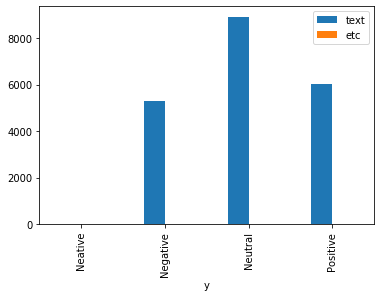

In [3]:
y_count = data.groupby('y').count()
display(y_count)
y_count.plot(kind='bar')

### ETC

 - useless data. drop whole etc data

In [4]:
data[~data['etc'].isna()].count()

text    7
y       7
etc     7
dtype: int64

# Preprocessing


## Preprocessing Raw Data


In [5]:
# Drop "Neative" or Null
data = data[data['y'] != 'Neative']
data = data[~data['text'].isna()]

# Label Encoding Y
y_labelencoder = LabelEncoder()
data['y'] = y_labelencoder.fit_transform(data.y)


# Random Over Sampling 
rus = RandomOverSampler(random_state=0)
x_data, y_data = rus.fit_resample(data[['text']], data['y'])

print('[Class Count]')
display(y_data.groupby(y_data).count())
data.head()

[Class Count]


y
0    8928
1    8928
2    8928
Name: y, dtype: int64

,text,y,etc
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,2,NaN
1,sahi bt h,2,NaN
2,"Kya bt hai,",2,NaN
3,Wah je wah,2,NaN
4,Are wha kaya bat hai,2,NaN


In [6]:
import re

emoji_pattern = re.compile(r"([😱😡😠😈😭😫😖😣😕😥😒😞😟🤔😲😤🔫👎😑😌🙄😦😩😯😏😅😂😹🤣🤗😀👅" 
                           r"😊😉😝♥️😍😄😁😛😜😃😆🤫😔😋👍❤♥️💋😘💜🙈💁🎁💃😚✌🏻😎💛👊👫💯😓🤓🤑🙋👭✋])")
_regex1 = re.compile(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’\!\.;,\'\?]")

def preprocess_token(x):
    x = emoji_pattern.sub(r' \1 ', x)
    x = _regex1.sub(' ', x)
    x = re.sub(r'\s+', ' ', x).strip()
    x = re.sub(r'\d+', ' \1 ', x)
    return x

# Preprocessing text
x_data.loc[:, 'text'] = x_data['text'].str.lower()
x_data.loc[:, 'text'] = x_data['text'].apply(preprocess_token)
x_data.join(y_data)

,text,y
0,sai kha ya her kisi kay bus ki bat nhi hai lak...,2
1,sahi bt h,2
2,kya bt hai,2
3,wah je wah,2
4,are wha kaya bat hai,2
...,...,...
26779,allah sab ki duain qabol farmain,2
26780,murshad da dedar hy lakh karoran hajjan,2
26781,mujy b ya drama had sa zyda acha lgta hai,2
26782,lahore pti chairman imran khan ne kal aala sat...,2


# Classification Model


In [7]:
x_train,x_test,y_train,y_test = train_test_split(x_data['text'].values, y_data.values, 
                                                 test_size=0.2, random_state=0)


print('[Train]')
display(pd.Series(y_train).groupby(y_train).count())
print('\n[Test]')
display(pd.Series(y_test).groupby(y_test).count())
print('\nx_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1, 2), max_df=0.3)
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)

[Train]


0    7158
1    7129
2    7140
dtype: int64


[Test]


0    1770
1    1799
2    1788
dtype: int64


x_train: (21427,)
y_train: (21427,)
x_test: (5357,)
y_test: (5357,)


## Linear SVM

In [8]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier

np.random.seed(0)

model = SGDClassifier(alpha=0.0001, max_iter=1000, class_weight={0:0.17, 1:0.4, 2:0.25})
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=y_labelencoder.classes_))

              precision    recall  f1-score   support

    Negative       0.83      0.82      0.83      1770
     Neutral       0.75      0.69      0.72      1799
    Positive       0.77      0.84      0.81      1788

    accuracy                           0.79      5357
   macro avg       0.79      0.79      0.78      5357
weighted avg       0.79      0.79      0.78      5357



## Analysis

the words strongly related to the negative class are such as "firing", "police", "murder", "injured" .. 

 - lanat: cursed
 - firing: firing
 - zakhmi: injured
 - janbahaq: Deliberate
 - firing se: By firing
 - police: police
 - jahil: Ignorant
 - sharam: shame
 - qatal: murder
 - pagal: crazy
 - mar: die

In [9]:
eli5.show_weights(model, vec=vectorizer, top=20, target_names=y_labelencoder.classes_)

In [10]:
_df = x_data[x_data['text'].str.contains('police')]
eli5.show_prediction(model, _df['text'].values[2], vec=vectorizer)